# Imports

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
import open3d as o3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Variables and constants

## Calibration

In [2]:
# image path to Left and Right chessboard to calibrate
cheesboard_LinkL = './chessboards/c2Left.png'
cheesboard_LinkR = './chessboards/c2Right.png'

#Left and right chessboards img and in grey
chessboard_imgL = cv.imread(cheesboard_LinkL)
chessboard_grayL = cv.cvtColor(chessboard_imgL, cv.COLOR_BGR2GRAY)

chessboard_imgR = cv.imread(cheesboard_LinkR)
chessboard_grayR = cv.cvtColor(chessboard_imgR, cv.COLOR_BGR2GRAY)


# Araays of Arrays to store object points and image points from all images
imgpointsL = [[]] # 2D points for calibration pattern
imgpointsR = [[]]  # 2D points for right image
objpoints = [[]]  # 3D points for IRL Right img



# Chessboards corners: Corners are found?, list of corners found
retL, cornersL = bool, []
retR, cornersR = bool,[]

#Calibration pattern points for the chessboard corners. 
objpL = []
objpR = []

termination_Criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

chessboard_size = chessboard_grayL.shape[::-1]

ProjectionMatrixL = [[]]
ProjectionMatrixR = [[]]

## Monkey

In [3]:
#Left and right monkey images
scanpathL = 'scanLeft/*.png'
scanpathR = 'scanRight/*.png'

#Color bounds (ie: Shades of red to accept)
lower_bound = np.array([0, 0, 210])  # Lower bound (B, G, R)
upper_bound = np.array([0, 0, 250])  # Upper bound (B, G, R)
colorBounds = [lower_bound, upper_bound] #Both together

#Coordinates of points in the color above
coordinatesL = [[]]
coordinatesR = [[]]

# List to store every points 
Total_pointsL = []
Total_pointsR = []

# Functions

## Calibration

## Matching Pairs and Epipolar Lines

In [4]:
# Calculate distances to epipolar lines
def dist_to_epipolar_line(points, lines):
    """
    Calculate the perpendicular distances of points to their corresponding epipolar lines.
    """
    return np.abs(np.sum(points * lines[:, :2], axis=1) + lines[:, 2]) / np.sqrt(np.sum(lines[:, :2]**2, axis=1))

def compute_epipolar_lines(ptsL, ptsR, F):
    """
    Compute epipolar lines for the given points using the fundamental matrix.
    """
    # Compute epipolar lines for points in the left and right images
    linesL = cv.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    linesR = cv.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
    return linesL, linesR

def filter_matches_by_epipolar_distance(ptsL, ptsR, linesL, linesR, threshold=1.0):
    """
    Filter points based on their distance to epipolar lines.
    """
    # Compute distances of points to their corresponding epipolar lines
    distL = dist_to_epipolar_line(ptsL, linesL)
    distR = dist_to_epipolar_line(ptsR, linesR)

    # Filter matches where distances are below the threshold
    mask = (distL < threshold) & (distR < threshold)
    matched_ptsL = ptsL[mask]
    matched_ptsR = ptsR[mask]
    return matched_ptsL, matched_ptsR

def find_matching_pairs(imgpointsL, imgpointsR, F, threshold=1.0):
    """
    Find matching point pairs and corresponding epipolar lines based on the fundamental matrix.
    """
    # Ensure points are in the correct shape
    ptsL = np.array(imgpointsL).reshape(-1, 2)
    ptsR = np.array(imgpointsR).reshape(-1, 2)

    # Compute epipolar lines
    linesL, linesR = compute_epipolar_lines(ptsL, ptsR, F)

    # Filter matches based on epipolar distances
    matched_ptsL, matched_ptsR = filter_matches_by_epipolar_distance(ptsL, ptsR, linesL, linesR, threshold)
    #print(matched_ptsL)
    #print("")
    #print(ptsL)
    
    return ptsL, ptsR, linesL, linesR

def draw_epipolar_lines(img, lines):
    """
    Draw epipolar lines on an image.
    """
    img_with_lines = img.copy()
    h, w, _ = img.shape

    for line in lines:
        A, B, C = line
        # Calculate the line endpoints
        x0, y0 = 0, int(-C / B)  # When x=0
        x1, y1 = w, int(-(C + A * w) / B)  # When x=w

        # Draw the line
        cv.line(img_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 1)  # Green color for lines

    return img_with_lines


## Monkey

In [5]:
def find_highlighted_pixels(image, color):
    #print(color)
    mask = cv.inRange(image, color[0], color[1])
    #plt.imshow(mask)
    #plt.show()

    # Find the coordinates of the pixels that match the color range
    coordinates = np.column_stack(np.where(mask > 0))
    return(coordinates)

#WARNING: This function might be a bit incorrect as it check for the best match in the left image only. It should check in the image with the least amount of points to be accurate.
#But because I use a lot of points here it doesn't matter and any mistakes isn't gonna be humanly visible
def find_matching_pairsMonkey(imgpointsL, imgpointsR, F, threshold=1.0):
    # Ensure points are in the correct shape
    ptsL = np.array(imgpointsL).reshape(-1, 2)
    ptsR = np.array(imgpointsR).reshape(-1, 2)
    
    # Compute epipolar lines for both images
    linesL = cv.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    linesR = cv.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
    
    
    matched_ptsL = []
    matched_ptsR = []
    matched_linesL = []
    matched_linesR = []
    
    # For each point in the left image
    for i, ptL in enumerate(ptsL):
        # Calculate distances to all epipolar lines in the right image
        distances = dist_to_epipolar_line(ptsR, linesR[i:i+1])
        
        # Find the best match (minimum distance)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        # If the best match is within the threshold
        if min_distance < threshold:
            matched_ptsL.append(ptL)
            matched_ptsR.append(ptsR[best_match_idx])
            matched_linesL.append(linesL[best_match_idx])
            matched_linesR.append(linesR[i])
    
    return (np.array(matched_ptsL), np.array(matched_ptsR), 
            np.array(matched_linesL), np.array(matched_linesR))

def triangulate_stereo_points(points_left, points_right, projectionMatrixL, projectionMatrixR):
    """
    Triangulate 3D points from stereo correspondences using camera parameters.
    
    Args:
        points_left: Nx2 array of points from left image
        points_right: Nx2 array of points from right image
        mtxL: 3x3 intrinsic matrix for left camera
        mtxR: 3x3 intrinsic matrix for right camera
        R: 3x3 rotation matrix between cameras
        T: 3x1 translation vector between cameras
    
    Returns:
        points_3d: Nx3 array of triangulated points
    """
    
    # Reshape points for cv.triangulatePoints
    print(points_left)
    print("")
    points_left = points_left.astype(np.float32).T
    print(points_left)
    points_right = points_right.astype(np.float32).T
    
    # Triangulate
    points_4d = cv.triangulatePoints(ProjectionMatrixL, ProjectionMatrixR, points_left, points_right)
    
    # Convert from homogeneous coordinates
    points_3d = points_4d[:3] / points_4d[3]
    points_3d = points_3d.T
    
    return points_3d

def create_open3d_point_cloud(points_3d, color_by_height=True):
    """
    Create an Open3D point cloud object from 3D points.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    
    if color_by_height:
        z_vals = points_3d[:, 2]
        colors = plt.cm.viridis((z_vals - z_vals.min()) / (z_vals.max() - z_vals.min()))[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd

def visualize_point_cloud(pcd):
    """
    Visualize point cloud with Open3D.
    """
    vis = o3d.visualization.Visualizer()
    vis.create_window("3D Point Cloud Viewer", width=1024, height=768)
    
    vis.add_geometry(pcd)
    
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    opt.show_coordinate_frame = True
    
    vc = vis.get_view_control()
    vc.set_zoom(0.8)
    vc.set_front([0, 0, -1])
    vc.set_lookat([0, 0, 0])
    vc.set_up([0, -1, 0])
    
    print("\nVisualization Controls:")
    print("- Left click + drag: Rotate")
    print("- Right click + drag: Pan")
    print("- Mouse wheel: Zoom")
    print("- Shift + left click: Rotate around model center")
    print("- [-] or [+]: Decrease/Increase point size")
    print("- [R]: Reset view")
    print("- [Q]/[Esc]: Exit")
    
    vis.run()
    vis.destroy_window()

def save_ply(points_3d, filename):
    """
    Save the 3D points to a PLY file.
    
    Args:
        points_3d: Nx3 array of 3D points
        filename: Name of the file to save the PLY data
    """
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {points_3d.shape[0]}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("end_header\n")
        for point in points_3d:
            f.write(f"{point[0]} {point[1]} {point[2]}\n")


# Chessboard

## Calibration

### Finding the corners

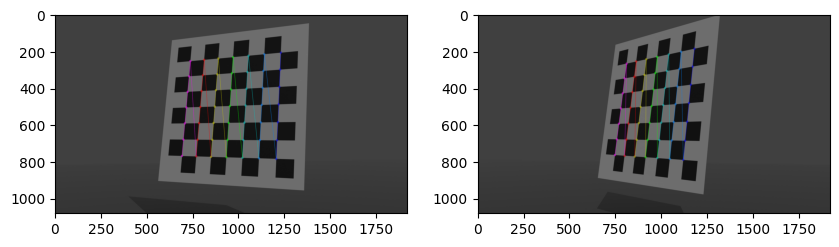

In [6]:
# Read in a calibration image
cheesboardLinkL = './chessboards/c2Left.png'
cheesboardLinkR = './chessboards/c2Right.png'

# Termination criteria for cornerSubPix

# On recherche un 7x7 dans l'image de gauche et de droite
objp = np.zeros((7*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)



objpoints = [] 
imgpointsR = []  
imgpointsL = []  


# Find chessboard corners in both images
retL, cornersL = cv.findChessboardCorners(chessboard_grayL, (7,7), None)
retR, cornersR = cv.findChessboardCorners(chessboard_grayR, (7,7), None)


# If corners are found in the first image
if retL and retR:

    objpoints.append(objp)
    imgpointsL.append(cornersL)
    imgpointsR.append(cornersR)

    
    # Draw the corners
    cv.drawChessboardCorners(chessboard_imgL, (7,7), cornersL, retL)
    cv.drawChessboardCorners(chessboard_imgR, (7,7), cornersR, retR)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(chessboard_imgL)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(chessboard_imgR)


### Calibrating the cameras

In [7]:
retL, mtxL, distL, rvecsL, tvecsL = cv.calibrateCamera(objpoints, imgpointsL, chessboard_size, None, None)
retR, mtxR, distR, rvecsR, tvecsR = cv.calibrateCamera(objpoints, imgpointsR, chessboard_size, None, None)
print(mtxL)


#On calibre les deux caméras en même temps
retS, mtxL, distL, mtxR, distR, R, T, E, F = cv.stereoCalibrate(
    objpoints, imgpointsL, imgpointsR,
    mtxL, distL, mtxR, distR,
    chessboard_size,
    criteria=termination_Criteria)


ProjectionMatrixR = np.dot(mtxR, np.hstack((R, T)))

ProjectionMatrixL = np.dot(mtxL, np.hstack((np.eye(3), np.zeros((3, 1)))))


# Projection matrix for the right camera (before rectification)


#Recitifcation transform (just in case for later)
RL, RR, PL, PR, Q, _, _ = cv.stereoRectify(mtxL, distL, mtxR, distR, chessboard_size, R, T)

np.save("PL.npy", PL)
np.save("PR.npy", PR)


[[2.18677859e+03 0.00000000e+00 8.93935025e+02]
 [0.00000000e+00 2.19871000e+03 5.22460927e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### 3D visualisation

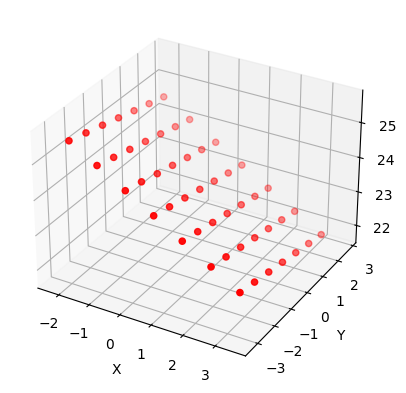

In [8]:
# Triangulate points
points_4D_homogeneous = cv.triangulatePoints(ProjectionMatrixL, ProjectionMatrixR, cornersL, cornersR)

# Convert homogeneous coordinates to 3D points
points_3D = points_4D_homogeneous[:3] / points_4D_homogeneous[3]
points_3D = points_3D.T  # Transpose to get (N, 3)

# Visualize 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Epipolar Lines

Found 49 matching points after filtering.


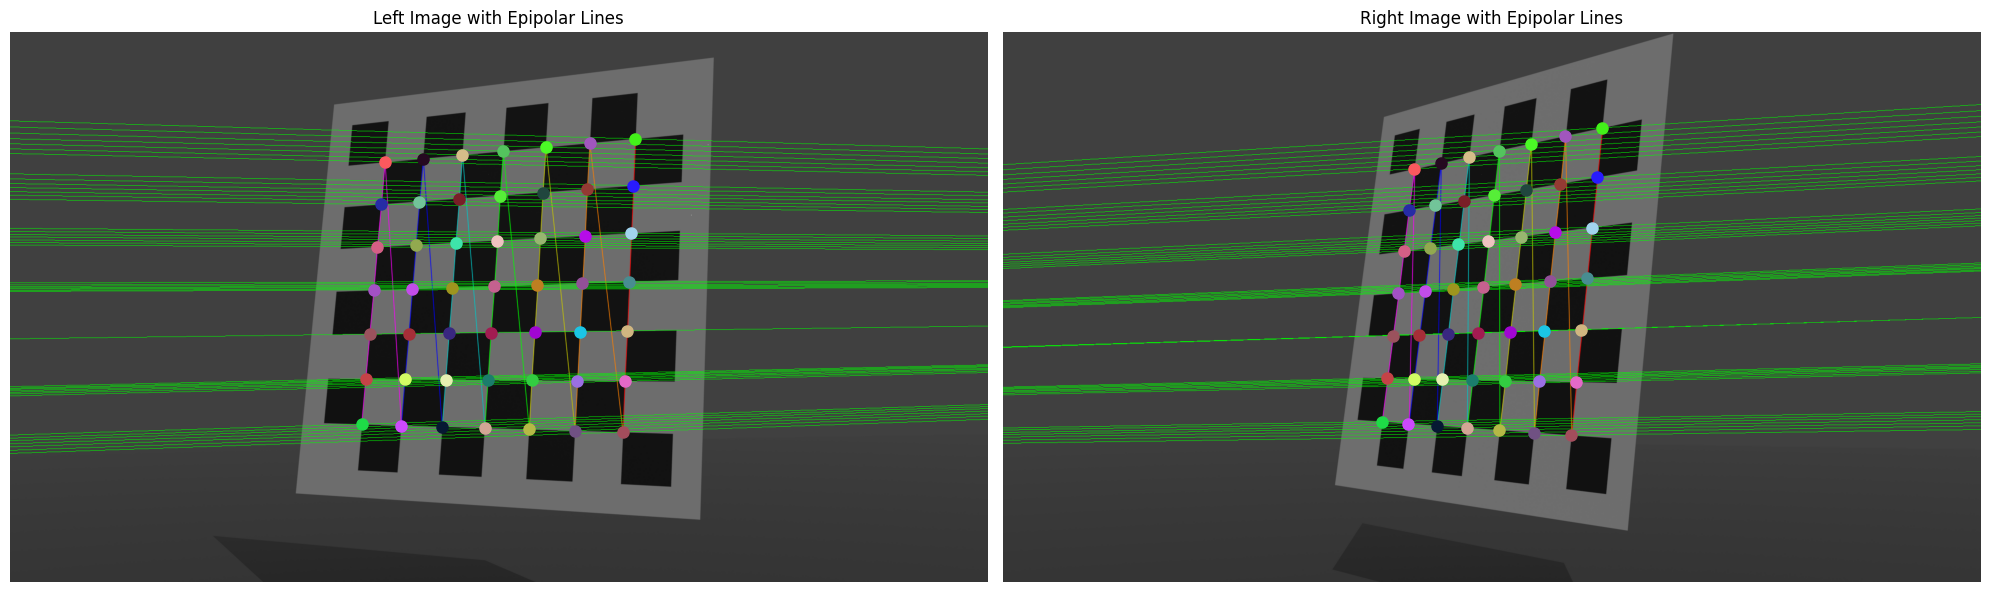

In [9]:
#Find all the points that match and their epipolar line
matched_ptsL, matched_ptsR, linesL, linesR = find_matching_pairs(imgpointsL[0], imgpointsR[0], F, threshold=2.0)
print(f"Found {len(matched_ptsL)} matching points after filtering.")

# Draw epipolar lines on the images
imgL_with_lines = draw_epipolar_lines(chessboard_imgL, linesL)
imgR_with_lines = draw_epipolar_lines(chessboard_imgR, linesR)

# Visualize the matches
# Plot images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv.cvtColor(imgL_with_lines, cv.COLOR_BGR2RGB))
ax2.imshow(cv.cvtColor(imgR_with_lines, cv.COLOR_BGR2RGB))

# Plot matching points
for i in range(len(matched_ptsL)):
    color = np.random.rand(3,)  # Random color
    ax1.plot(matched_ptsL[i, 0], matched_ptsL[i, 1], 'o', color=color, markersize=8)
    ax2.plot(matched_ptsR[i, 0], matched_ptsR[i, 1], 'o', color=color, markersize=8)
    
# Configure plot
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Left Image with Epipolar Lines')
ax2.set_title('Right Image with Epipolar Lines')
plt.tight_layout()
plt.show()

# Monkey

## A Small Test

### Matching points and Epipolar Lines

Number of matching pixels:
157
270
Found 157 matching points after filtering


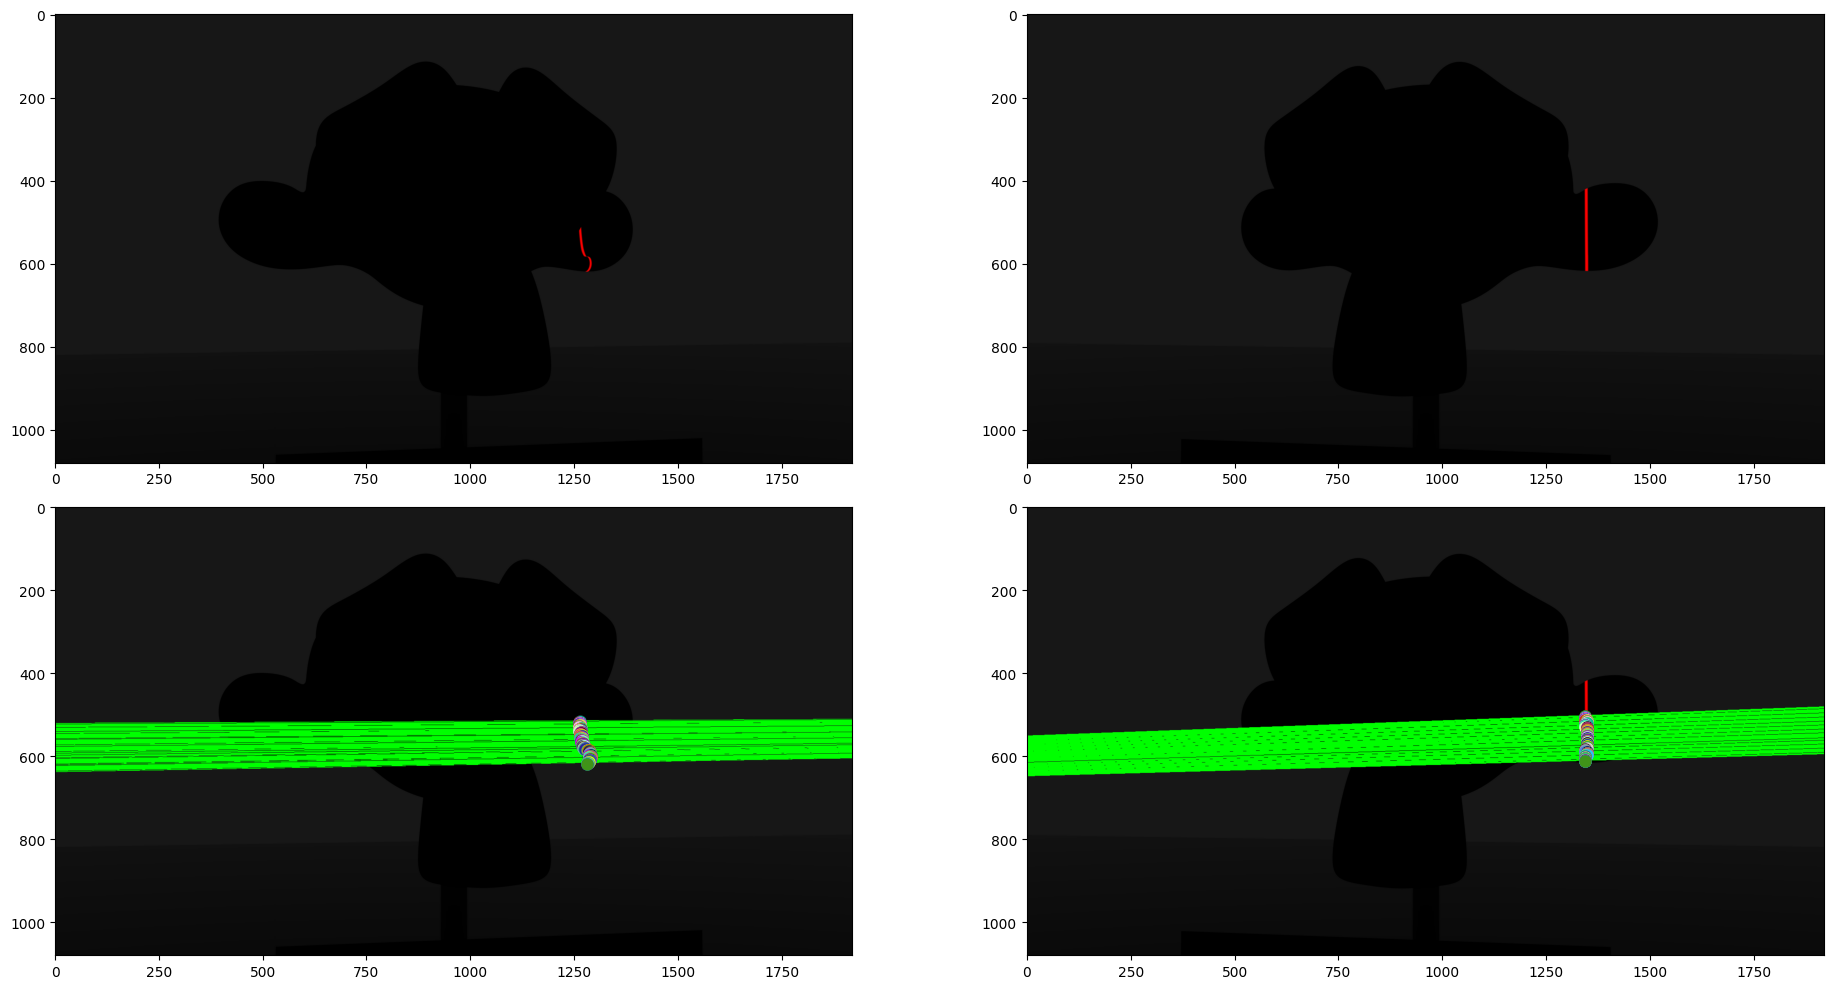

In [10]:
scanpathL = 'scanLeft/*.png'
scanpathR = 'scanRight/*.png'


imgL = cv.imread('./scanLeft/0007.png')
imgR = cv.imread('./scanRight/scan0007.png')


imgpointsL = []
imgpointsR = []

coordinatesL = find_highlighted_pixels(imgL, colorBounds)
coordinatesR = find_highlighted_pixels(imgR, colorBounds)


# Print the coordinates of matching pixels
print("Number of matching pixels:")
print(len(coordinatesL))
print(len(coordinatesR))


#Test with inverted coordinates because maybe its y x and not x y like a normal fucking human being
inverted_coordinatesL = [[y, x] for x, y in coordinatesL]
inverted_coordinatesR = [[y, x] for x, y in coordinatesR]
inverted_coordinatesR = np.array(inverted_coordinatesR)
inverted_coordinatesL = np.array(inverted_coordinatesL)


#print(inverted_coordinatesL)

#Compute epipolar lines
linesL = cv.computeCorrespondEpilines(inverted_coordinatesR.reshape(-1,1,2), 2, F)
linesR = cv.computeCorrespondEpilines(inverted_coordinatesL.reshape(-1, 1, 2), 1, F)
linesL = linesL.reshape(-1, 3)
linesR = linesR.reshape(-1, 3)


matched_ptsL, matched_ptsR, linesL, linesR = find_matching_pairsMonkey(inverted_coordinatesL, inverted_coordinatesR, F, threshold=1.0)
print(f"Found {len(matched_ptsL)} matching points after filtering")

# Create a new figure
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Draw epipolar lines on images
imgL_with_lines = draw_epipolar_lines(imgL, linesL)
imgR_with_lines = draw_epipolar_lines(imgR, linesR)

# Display the images 
ax[0,0].imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
ax[0,1].imshow(cv.cvtColor(imgR, cv.COLOR_BGR2RGB))

ax[1,0].imshow(cv.cvtColor(imgL_with_lines, cv.COLOR_BGR2RGB))
ax[1,1].imshow(cv.cvtColor(imgR_with_lines, cv.COLOR_BGR2RGB))

# Plot points
for i in range(len(matched_ptsL)):
    color = np.random.rand(3,)
    ax[1,0].plot(matched_ptsL[i, 0], matched_ptsL[i, 1], 'o', color=color, markersize=8)
    ax[1,1].plot(matched_ptsR[i, 0], matched_ptsR[i, 1], 'o', color=color, markersize=8)
    

plt.tight_layout()
plt.show() 

### 

## The real deal

### Finding the matching points on each pictures

In [11]:
# Used to go throgh all the files
png_filesL = glob.glob(scanpathL)
png_filesR = glob.glob(scanpathR)

#To make sure it's in the right order
png_filesL.sort()
png_filesR.sort()



# Loop over the indices and process corresponding files from both lists
for i in range(min(len(png_filesL), len(png_filesR))):  # Ensure you don't go out of bounds
    #print(f"Left file: {png_filesL[i]}")
    #print(f"Right file: {png_filesR[i]}")
    
    imgL = cv.imread(f"./{png_filesL[i]}")
    imgR = cv.imread(f"./{png_filesR[i]}")

    coordinatesL = find_highlighted_pixels(imgL, colorBounds)
    coordinatesR = find_highlighted_pixels(imgR, colorBounds)

    # Print the number of matching pixels
    #print("Number of matching pixels:")
    #print(len(coordinatesL))
    #print(len(coordinatesR))

    # Invert coordinates (to switch y, x to x, y)
    inverted_coordinatesL = [[y, x] for x, y in coordinatesL]
    inverted_coordinatesR = [[y, x] for x, y in coordinatesR]



    # Check if there are any valid points to process
    if len(inverted_coordinatesL) > 0 and len(inverted_coordinatesR) > 0:
        # Find matching pairs and epipolar lines
        matched_ptsL, matched_ptsR, linesL, linesR = find_matching_pairsMonkey(
            inverted_coordinatesL, inverted_coordinatesR, F, threshold=1)

        # Append the matched points to the total lists
        Total_pointsL.append(matched_ptsL)
        Total_pointsR.append(matched_ptsR)

        print(f"Found {len(matched_ptsL)} matching points after filtering")

# After the loop, convert the lists to NumPy arrays for further processing
if Total_pointsL:
    Total_pointsL = np.vstack(Total_pointsL)  # Stack them vertically into one NumPy array
if Total_pointsR:
    Total_pointsR = np.vstack(Total_pointsR)

print(f"Total points left: {Total_pointsL.shape}")
print(f"Total points right: {Total_pointsR.shape}")
# Save Total_pointsL and Total_pointsR as .npy files
np.save("Total_pointsL.npy", Total_pointsL)
np.save("Total_pointsR.npy", Total_pointsR)

print("Points saved to Total_pointsL.npy and Total_pointsR.npy")






Found 93 matching points after filtering
Found 211 matching points after filtering
Found 256 matching points after filtering
Found 225 matching points after filtering
Found 157 matching points after filtering
Found 250 matching points after filtering
Found 542 matching points after filtering
Found 644 matching points after filtering
Found 1021 matching points after filtering
Found 1248 matching points after filtering
Found 1148 matching points after filtering
Found 1312 matching points after filtering
Found 788 matching points after filtering
Found 659 matching points after filtering
Found 332 matching points after filtering
Found 195 matching points after filtering
Found 265 matching points after filtering
Found 280 matching points after filtering
Found 243 matching points after filtering
Found 181 matching points after filtering
Found 2 matching points after filtering
Total points left: (10052, 2)
Total points right: (10052, 2)
Points saved to Total_pointsL.npy and Total_pointsR.npy


### 3D plot

In [12]:
try:
    # Load your matched points
    points_left = np.load("Total_pointsL.npy")
    points_right = np.load("Total_pointsR.npy")
    
    print(f"Loaded {len(points_left)} points")
    
    # Triangulate points
    print("Triangulating points...")
    points_3d = triangulate_stereo_points(points_left, points_right, ProjectionMatrixL, ProjectionMatrixR)   

    save_ply(points_3d, "points3D.ply")
    print("Filtered points saved to 'points3D.ply'")

    # Create Open3D point cloud
    print("Creating point cloud...")
    pcd = create_open3d_point_cloud(points_3d)
    

    # Print statistics
    print("\nPoint Cloud Statistics:")
    bounds = points_3d.min(axis=0), points_3d.max(axis=0)
    print(f"X range: {bounds[0][0]:.2f} to {bounds[1][0]:.2f}")
    print(f"Y range: {bounds[0][1]:.2f} to {bounds[1][1]:.2f}")
    print(f"Z range: {bounds[0][2]:.2f} to {bounds[1][2]:.2f}")
    
    # Visualize
    print("\nLaunching visualization...")
    visualize_point_cloud(pcd)
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nTroubleshooting:")
    print("1. Make sure you have the required libraries installed:")
    print("   pip install numpy opencv-python open3d")
    print("2. Verify that your point files exist and are properly formatted")
    print("3. Check that your camera calibration parameters are correct")


Loaded 10052 points
Triangulating points...
[[1375  467]
 [1376  471]
 [1378  472]
 ...
 [ 413  549]
 [ 398  489]
 [ 398  490]]

[[1375. 1376. 1378. ...  413.  398.  398.]
 [ 467.  471.  472. ...  549.  489.  490.]]
Filtered points saved to 'points3D.ply'
Creating point cloud...

Point Cloud Statistics:
X range: -5.70 to 5.97
Y range: -4.02 to 3.62
Z range: 19.70 to 26.91

Launching visualization...

Visualization Controls:
- Left click + drag: Rotate
- Right click + drag: Pan
- Mouse wheel: Zoom
- Shift + left click: Rotate around model center
- [-] or [+]: Decrease/Increase point size
- [R]: Reset view
- [Q]/[Esc]: Exit
